# Module Project: Hyperparameter Tuning
This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Establish the baseline accuracy score for your dataset.
- **Task 4:** Build `clf_dt`.
- **Task 5:** Build `clf_rf`.
- **Task 6:** Evaluate classifiers using k-fold cross-validation.
- **Task 7:** Tune hyperparameters for best performing classifier.
- **Task 8:** Print out best score and params for model.
- **Task 9:** Create `submission.csv` and upload to Kaggle.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

# I. Wrangle Data

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv',
             DATA_PATH + 'waterpumps/train_labels.csv')
X_test = wrangle(DATA_PATH + 'waterpumps/test_features.csv')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
X = df.drop(columns='status_group')
y = df['status_group']

# III. Establish Baseline

**Task 3:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430899510092763


# IV. Build Models

**Task 4:** Build a `Pipeline` named `clf_dt`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` Predictor.

**Note:** Do not train `clf_dt`. You'll do that in a subsequent task.

In [ ]:
clf_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42))

**Task 5:** Build a `Pipeline` named `clf_rf`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Do not train `clf_rf`. You'll do that in a subsequent task.

In [ ]:
clf_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators =25, random_state=42)
);

# V. Check Metrics

**Task 6:** Evaluate the performance of both of your classifiers using k-fold cross-validation.

In [ ]:
cv_scores_dt = cross_val_score(clf_dt, X, y, cv=5)
cv_scores_rf = cross_val_score(clf_rf, X, y, cv=5, n_jobs=-1)

In [ ]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.75631313 0.7506734  0.75319865 0.76018519 0.75183096]
Mean CV accuracy score: 0.7544402665145152
STD CV accuracy score: 0.0034365990156498146


In [ ]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.80412458 0.79924242 0.8023569  0.7973064  0.79737352]
Mean CV accuracy score: 0.8000807638639106
STD CV accuracy score: 0.002729921641681423


# VI. Tune Model

**Task 7:** Choose the best performing of your two models and tune its hyperparameters using a `RandomizedSearchCV` named `model`. Make sure that you include cross-validation and that `n_iter` is set to at least `25`.

**Note:** If you're not sure which hyperparameters to tune, check the notes from today's guided project and the `sklearn` documentation.

In [ ]:
from scipy.stats import randint, uniform
param_distributions = {
    'randomforestclassifier__n_estimators': [25, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__bootstrap': [True, False]
}

In [ ]:
clf_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
model = RandomizedSearchCV(
    clf_rf,
    param_distributions=param_distributions,
    n_iter=25,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [ ]:
model.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [None,
                                                                              10,
                                                                              20,
                                                                              30],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [25,
                                                                                 50,
                                                                                 100,
                                                                                 200]},
                   random_state=42, scoring='accuracy')

**Task 8:** Print out the best score and best params for `model`.

In [ ]:
best_score = model.best_score_
best_params =  model.best_params_
print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8110237260502433
Best params for `model`: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__bootstrap': False}


# Communicate Results

**Task 9:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

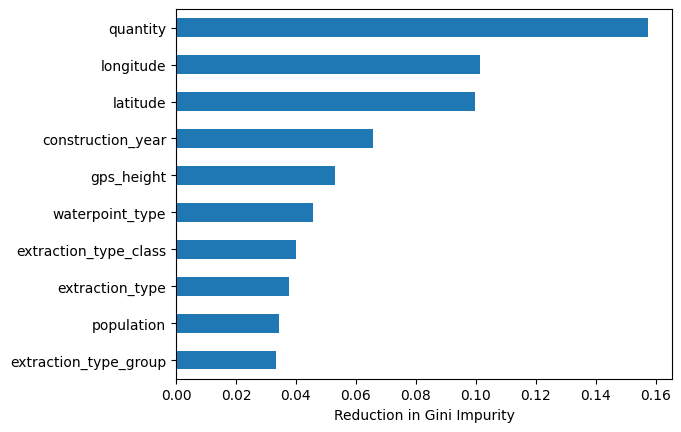

In [38]:
bestestimator = model.best_estimator_
importances = bestestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [ ]:
submission = pd.DataFrame(index=X_test.index, columns=['status_group'], data=y_pred)

In [ ]:
submission.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [ ]:
datestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H%M_') #string from time format
submission.to_csv(f'{datestamp}submission.csv')